In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import csv
import tensorflow as tf
import zipfile
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import Input, Model
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import concatenate
from keras.optimizers import Adam

In [2]:
!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!kaggle datasets download -d trolukovich/food5k-image-dataset

100% 425M/426M [00:14<00:00, 30.6MB/s]
100% 426M/426M [00:14<00:00, 30.5MB/s]


In [4]:
with zipfile.ZipFile('/content/food5k-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
TRAINING_PATH = '/content/training'
VALIDATION_PATH = '/content/validation'

In [6]:
train_food_path = os.path.join(TRAINING_PATH, 'food')
train_nonfood_path = os.path.join(TRAINING_PATH, 'non_food')

validation_food_path = os.path.join(VALIDATION_PATH, 'food')
validation_nonfood_path = os.path.join(VALIDATION_PATH, 'non_food')

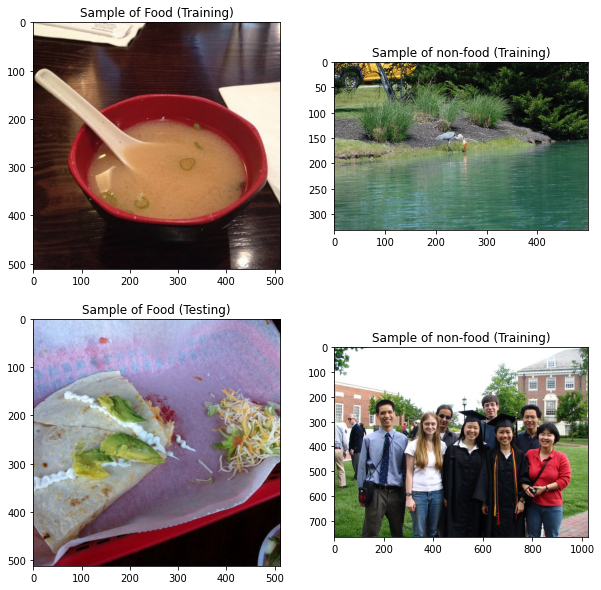

In [11]:
index = 10

plt.figure(figsize=(10,10))
plt.subplot(221).set_title("Sample of Food (Training)")
plt.imshow(plt.imread(os.path.join(train_food_path, os.listdir(train_food_path)[index])))
plt.subplot(222).set_title("Sample of non-food (Training)")
plt.imshow(plt.imread(os.path.join(train_nonfood_path, os.listdir(train_food_path)[index])))
plt.subplot(223).set_title("Sample of Food (Testing)")
plt.imshow(plt.imread(os.path.join(validation_food_path, os.listdir(validation_food_path)[index])))
plt.subplot(224).set_title("Sample of non-food (Training)")
plt.imshow(plt.imread(os.path.join(validation_nonfood_path, os.listdir(validation_nonfood_path)[index])))

In [12]:
training_food_size = len(os.listdir(os.path.join(TRAINING_PATH, 'food')))
training_nonfood_size = len(os.listdir(os.path.join(TRAINING_PATH, 'non_food')))
validation_food_size = len(os.listdir(os.path.join(VALIDATION_PATH, 'food')))
validation_nonfood_size = len(os.listdir(os.path.join(VALIDATION_PATH, 'non_food')))

print(f'There are {training_food_size} food samples and {training_nonfood_size} non-food samples in the training set')
print(f'There are {validation_food_size} food samples and {validation_nonfood_size} non-food samples in the validation set')

There are 1500 food samples and 1500 non-food samples in the training set
There are 500 food samples and 500 non-food samples in the validation set


In [23]:
target_shape = 150
training_batch = 128

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_PATH,
                                                    # batch_size=training_batch,
                                                    class_mode='binary',
                                                    target_size=(target_shape, target_shape))

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_PATH,
                                                    class_mode='binary',
                                                    target_size=(target_shape, target_shape))

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
training_shape = plt.imread(os.path.join(train_food_path, os.listdir(train_food_path)[0])).shape
validation_shape = plt.imread(os.path.join(validation_food_path, os.listdir(validation_food_path)[0])).shape
print(f'The shape of training images is 3d {training_shape}')
print(f'The shape of validation images is also 3d {validation_shape}')

The shape of training images is 3d (512, 512, 3)
The shape of validation images is also 3d (512, 512, 3)


In [17]:
labels = list(train_generator.class_indices)
labels

['food', 'non_food']

In [18]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

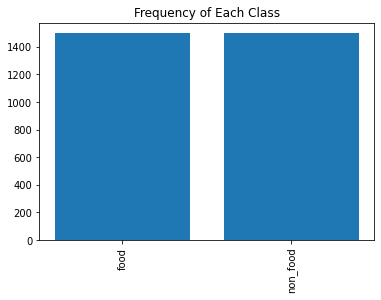

In [19]:
values, counts = np.unique(train_generator.labels, return_counts=True)

plt.xticks(rotation=90)
plt.bar(x=labels, height=counts)
plt.title("Frequency of Each Class")
plt.show()

In [30]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(target_shape, target_shape, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['acc'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 32)      

In [31]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
94/94 [==============================] - 38s 397ms/step - loss: 0.5841 - acc: 0.6923 - val_loss: 0.4505 - val_acc: 0.7990
Epoch 2/20
94/94 [==============================] - 35s 374ms/step - loss: 0.4796 - acc: 0.7833 - val_loss: 0.4317 - val_acc: 0.8130
Epoch 3/20
94/94 [==============================] - 35s 375ms/step - loss: 0.4403 - acc: 0.8100 - val_loss: 0.3330 - val_acc: 0.8690
Epoch 4/20
94/94 [==============================] - 35s 369ms/step - loss: 0.3991 - acc: 0.8280 - val_loss: 0.3289 - val_acc: 0.8700
Epoch 5/20
94/94 [==============================] - 35s 372ms/step - loss: 0.3735 - acc: 0.8437 - val_loss: 0.2895 - val_acc: 0.8730
Epoch 6/20
94/94 [==============================] - 40s 425ms/step - loss: 0.3545 - acc: 0.8473 - val_loss: 0.3063 - val_acc: 0.8800
Epoch 7/20
94/94 [==============================] - 35s 377ms/step - loss: 0.3585 - acc: 0.8500 - val_loss: 0.2689 - val_acc: 0.8930
Epoch 8/20
94/94 [==============================] - 36s 378ms/step - 

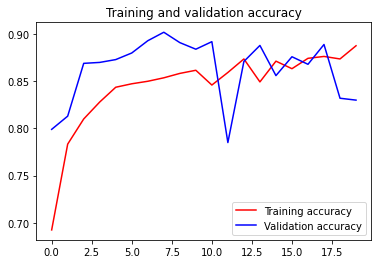

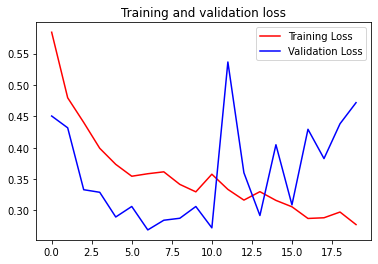

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see the model is overfitting after 10 epochs.

In [41]:
model.evaluate_generator(validation_generator)

<ipython-input-41-8951cfd684a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


[0.4718337059020996, 0.8299999833106995]